# Creating Cohorts of Songs: The Rolling Stones

## Project Overview
This project uses unsupervised machine learning to create cohorts of songs from The Rolling Stones' Spotify catalog. The goal is to group songs based on their intrinsic audio features to power a more intelligent song recommendation system. The project involves data cleaning, exploratory data analysis (EDA), and K-Means clustering.

### Step 1: Data Loading and Initial Quality Check


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_songs = pd.read_csv('rolling_stones_spotify.csv')

# Refine: Drop the redundant index column
if 'Unnamed: 0' in df_songs.columns:
    df_songs.drop('Unnamed: 0', axis=1, inplace=True)

print("--- Initial Data Inspection ---")
print(df_songs.info())

print("\n--- Missing Values & Duplicates Check ---")
print(f"Missing values: {df_songs.isnull().sum().sum()}")
print(f"Duplicate songs (by ID): {df_songs.duplicated(subset=['id']).sum()}")


--- Initial Data Inspection ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1610 non-null   object 
 1   album             1610 non-null   object 
 2   release_date      1610 non-null   object 
 3   track_number      1610 non-null   int64  
 4   id                1610 non-null   object 
 5   uri               1610 non-null   object 
 6   acousticness      1610 non-null   float64
 7   danceability      1610 non-null   float64
 8   energy            1610 non-null   float64
 9   instrumentalness  1610 non-null   float64
 10  liveness          1610 non-null   float64
 11  loudness          1610 non-null   float64
 12  speechiness       1610 non-null   float64
 13  tempo             1610 non-null   float64
 14  valence           1610 non-null   float64
 15  popularity        1610 non-null   int64  
 16  duration_m

### Step 2: Exploratory Data Analysis (EDA)

C:\Users\ThapeloMasebe\AppData\Local\Temp\ipykernel_42072\1355599712.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=album_popularity.head(10).values, y=album_popularity.head(10).index, palette='viridis')


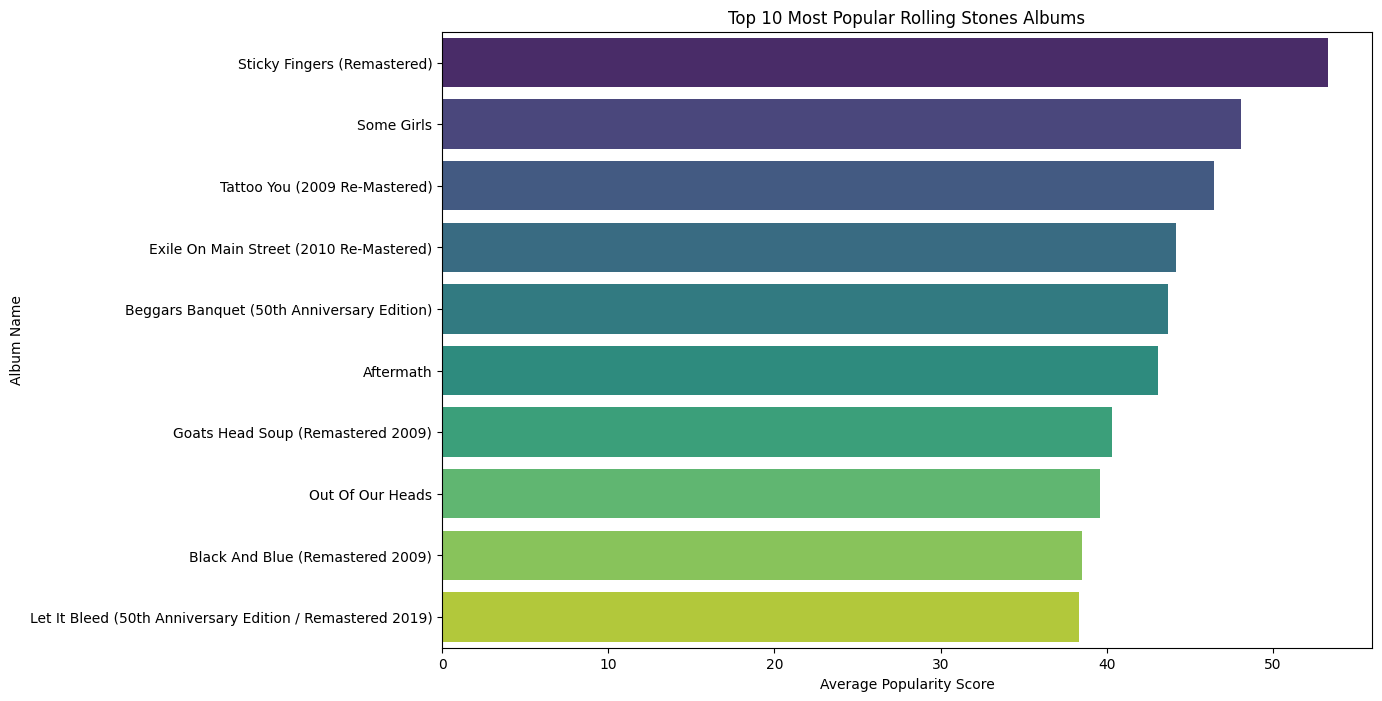

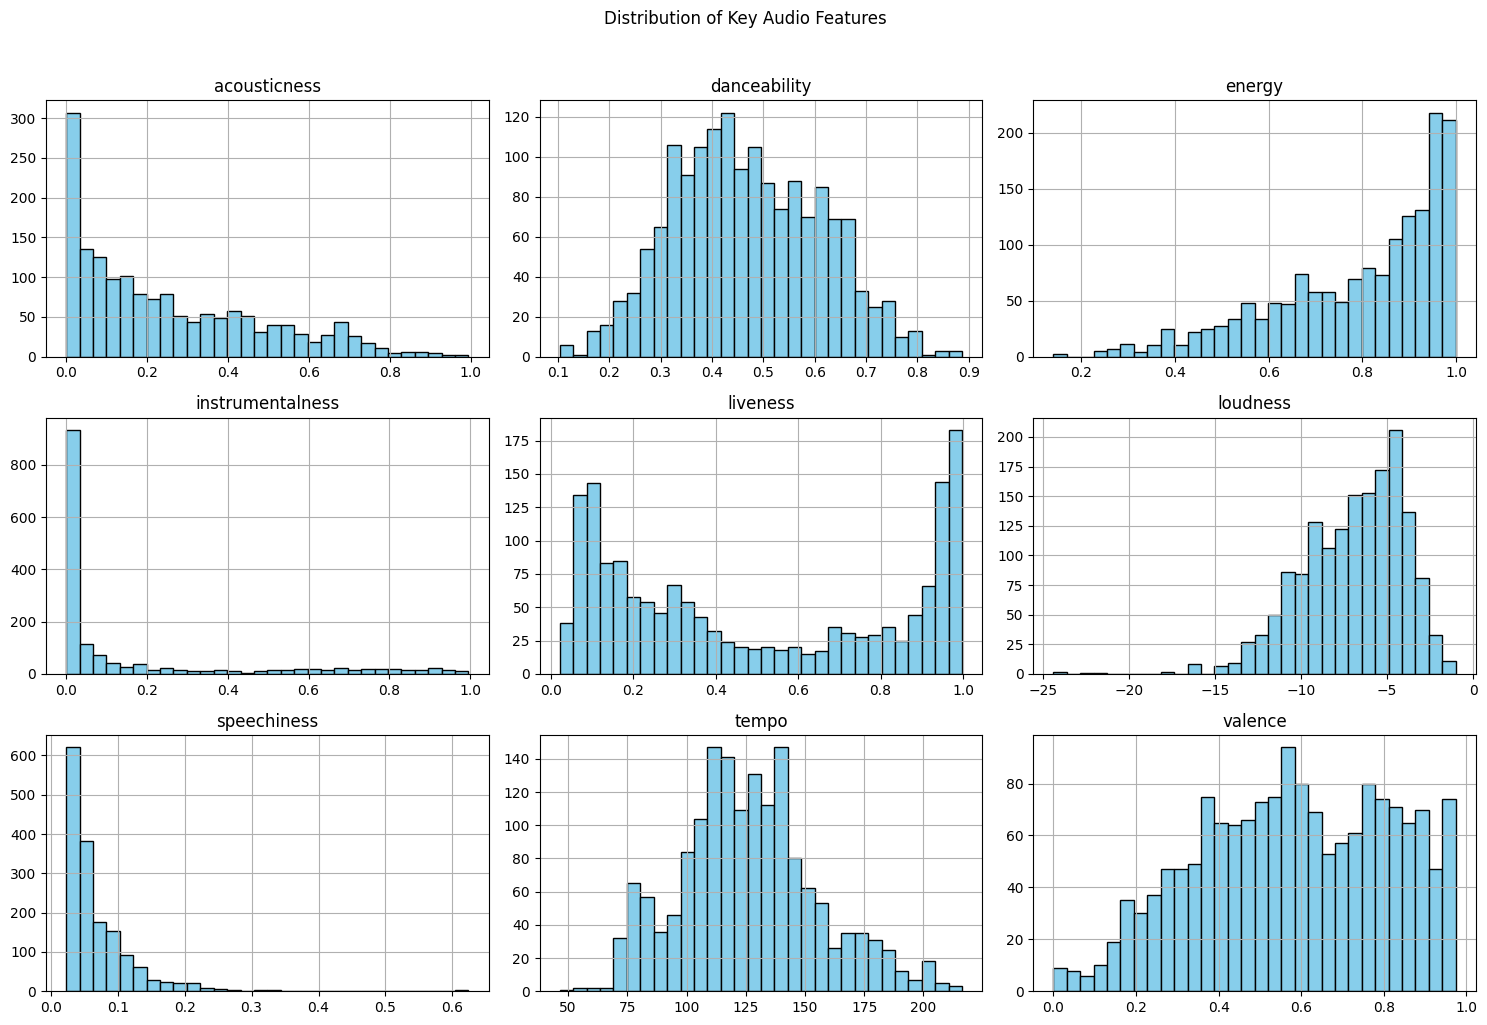

In [2]:
# Identify top albums by average song popularity
album_popularity = df_songs.groupby('album')['popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=album_popularity.head(10).values, y=album_popularity.head(10).index, palette='viridis')
plt.title('Top 10 Most Popular Rolling Stones Albums')
plt.xlabel('Average Popularity Score')
plt.ylabel('Album Name')
plt.show()

# Explore audio feature distributions
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df_songs[audio_features].hist(figsize=(15, 10), bins=30, layout=(3, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Key Audio Features', y=1.02)
plt.tight_layout()
plt.show()


### Step 3: Finding the Optimal Number of Clusters (Elbow Method)

c:\Users\ThapeloMasebe\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ThapeloMasebe\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\ThapeloMasebe\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ThapeloMasebe\AppData\Local\Programs\Python\Python3

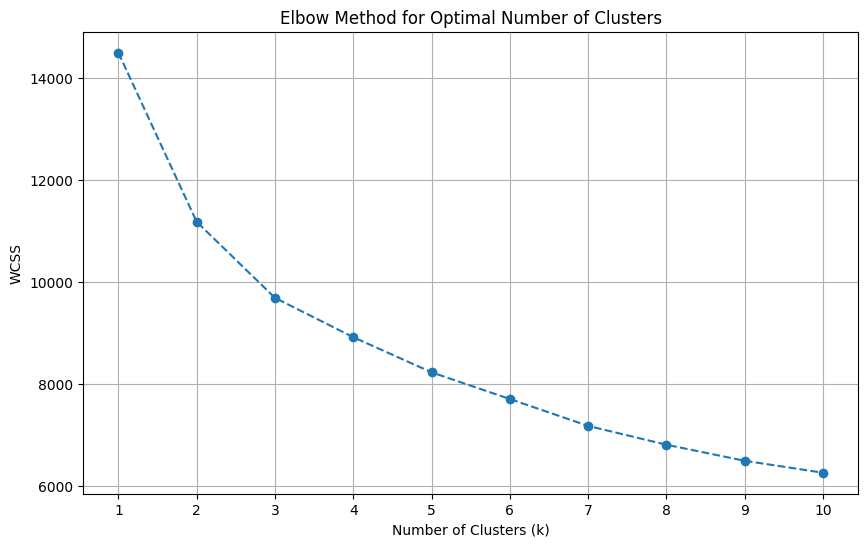

Conclusion: The elbow is clearly visible at k=4. This is our optimal number of clusters.


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select and scale features for clustering
df_cluster = df_songs[audio_features]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Use the Elbow Method
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Conclusion: The elbow is clearly visible at k=4. This is our optimal number of clusters.")


### Step 4: Final Clustering and Cohort Analysis

--- Average Audio Features per Cohort ---
         acousticness  danceability    energy  instrumentalness  liveness  \
cluster                                                                     
0            0.164389      0.562323  0.804292          0.055185  0.293337   
1            0.189764      0.357612  0.925273          0.113396  0.829389   
2            0.242108      0.509278  0.831919          0.739995  0.414718   
3            0.459738      0.487765  0.558043          0.076577  0.296272   

         loudness  speechiness       tempo   valence  
cluster                                               
0       -6.817465     0.048978  122.549247  0.766692  
1       -5.333290     0.108584  138.130271  0.441849  
2       -6.706343     0.053962  125.883010  0.736678  
3       -9.749886     0.047221  113.018754  0.461811  


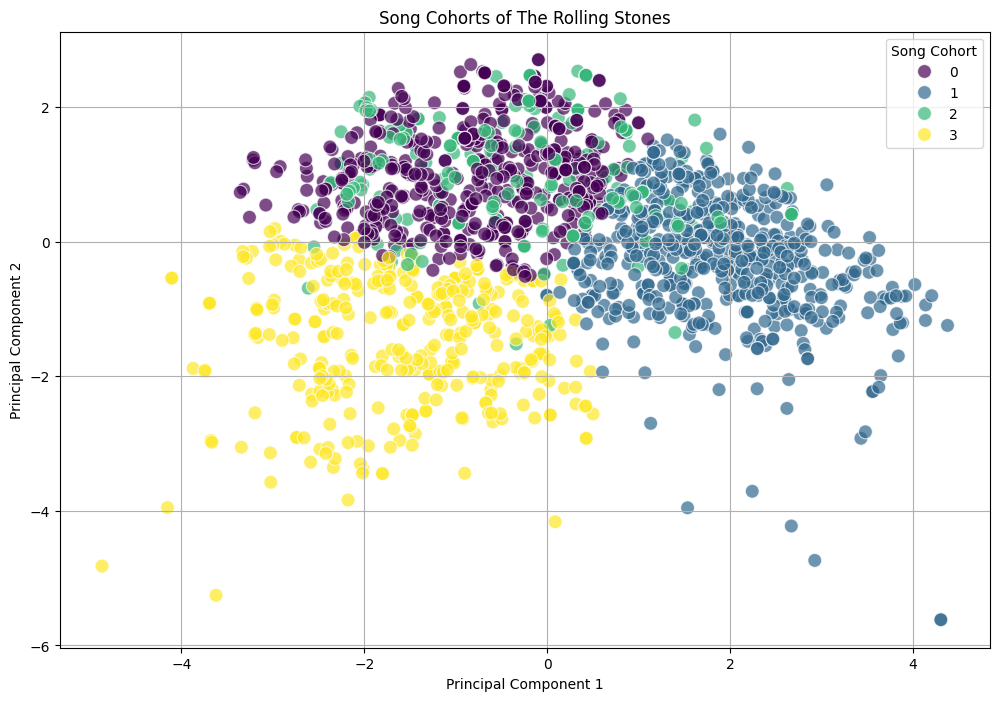

In [4]:
from sklearn.decomposition import PCA

# Perform K-Means with k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)
df_songs['cluster'] = cluster_labels

# Analyze cluster characteristics
print("--- Average Audio Features per Cohort ---")
cluster_summary = df_songs.groupby('cluster')[audio_features].mean()
print(cluster_summary)

# Visualize clusters with PCA
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_cluster_scaled)
df_songs['pca1'] = df_pca[:, 0]
df_songs['pca2'] = df_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df_songs, palette='viridis', s=100, alpha=0.7)
plt.title('Song Cohorts of The Rolling Stones')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Song Cohort')
plt.grid(True)
plt.show()
